### Following code is a slightly modified code, that was provided by Hauke Bartsch from the following link: https://github.com/mmiv-center/Research-Information-System/blob/master/components/Workflow-Image-AI/src/templates/python/stub.py

In [99]:
import pydicom
import glob
import numpy as np
import sys
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Remember to comment out which datafolders you're not using, according to your machine

The following folders are the paths for the alienware-ubuntu machine at MMIV 

In [100]:
def which_computer_folder(which_computer: str):
    if which_computer == "home":
        datafolder = "C:/Users/Heris/OneDrive/Dokumenter/data/"
        outputfolder = "C:/Users/Heris/OneDrive/Dokumenter/data/OUTPUT/"
    elif which_computer == "mmiv":
        datafolder = "/home/heris/data/LIDC-IDRI/"
        outputfolder = "/home/heris/data/OUTPUT/LIDC-IDRI/"
    elif which_computer != "home" or which_computer != "mmiv":
        raise ValueError
    return datafolder, outputfolder

In [101]:
datafolder , outputfolder = which_computer_folder("mmiv")
# datafolder , outputfolder = which_computer_folder("home")

In [102]:
metadata = pd.read_csv(datafolder+"metadata.csv")
columns = metadata.columns
metadata = metadata[metadata["Number of Images"] >= 10]
# columns
metadata["Modality"]



2     CT
3     CT
4     CT
8     CT
9     CT
12    CT
14    CT
15    CT
19    CT
20    CT
21    CT
24    CT
27    CT
28    CT
30    CT
32    CT
34    CT
35    CT
37    CT
Name: Modality, dtype: object

In [103]:
if not(os.path.exists(outputfolder)):
    try:
        os.mkdir(outputfolder,0o777)
    except OSError as error:
        (error)

files = []
lidc_idri_00xx = []
for root, dirs, the_files in os.walk(datafolder):
    lidc_idri_00xx = []
    # len(dirs) = 0 tells us that we're in the final folder, and 
    # len(the_files) >= 10 tells us that we only want to look at folders with more than 10 images, 
    # CT is usually only the ones that have that many images 
    """ print(root, dirs, the_files) """
    """ path = root + "/" + the_files """
    """ if os.path.isdir(path):
        continue """
    
    if len(dirs) == 0 and len(the_files) >= 10:
        lidc_idri_00xx = [] #Put every dicom files associated with one person in seperate lists, because the code below this cell if for a single volume
        for dicomfile in the_files: 
            path = root+"/"+dicomfile
            if os.path.isfile(path):
                try: 
                    dicom = pydicom.dcmread(path)
                    dicom.Modality
                    lidc_idri_00xx.append(dicom)
                except Exception as e: 
                    continue 
    if len(lidc_idri_00xx) > 0:
        files.append(lidc_idri_00xx) #NB: Its a list with the dicomfiles that gets appended
        
    

In [104]:
len(files)

19

In [60]:
n = 0
for i in range(len(files)):
    if i>0: 
        n+=1
        if str(files[i-1].PatientID) != str(files[i].PatientID):
            print(str(files[i-1].PatientID) +": "+str(n)+" images")
            n=0

LIDC-IDRI-0017: 238 images
LIDC-IDRI-0016: 141 images
LIDC-IDRI-0007: 145 images
LIDC-IDRI-0013: 125 images
LIDC-IDRI-0012: 128 images
LIDC-IDRI-0006: 133 images
LIDC-IDRI-0014: 114 images
LIDC-IDRI-0018: 127 images
LIDC-IDRI-0005: 133 images
LIDC-IDRI-0001: 133 images
LIDC-IDRI-0011: 128 images
LIDC-IDRI-0002: 261 images
LIDC-IDRI-0015: 209 images
LIDC-IDRI-0003: 140 images
LIDC-IDRI-0009: 256 images
LIDC-IDRI-0010: 277 images
LIDC-IDRI-0019: 305 images
LIDC-IDRI-0008: 133 images


In [109]:
# make sure we only keep data that has the same shape as the first slice
for i in range(len(files)):
    files[i] = [a for a in files[i] if a.get("PixelData") != None and a.pixel_array.shape == files[i][0].pixel_array.shape]
#files = [a for a in files if a.get("PixelData") != None and a.pixel_array.shape == files[0].pixel_array.shape]

# print("file count: {}".format(len(files[0])))

# make sure we sort the slices by SliceLocation or, if that does not exist by InstanceNumber
def sortFunc(s):
    if "SliceLocation" in s:
        return s.SliceLocation
    else:
        if "InstanceNumber" in s:
            return s.InstanceNumber
        return 0

sup_slices = [] #supremum, the list above

for i in range(len(files)):
    slices = sorted(files[i], key=sortFunc) #slices contains many dcm files, and is a list as well 
    sup_slices.append(slices)
# print(slices[1].filename)



In [95]:
print("file count: {}".format(len(files)))

file count: 96


In [78]:
str(slices[3].PatientID)

'LIDC-IDRI-0019'

In [114]:
import nibabel as nib 

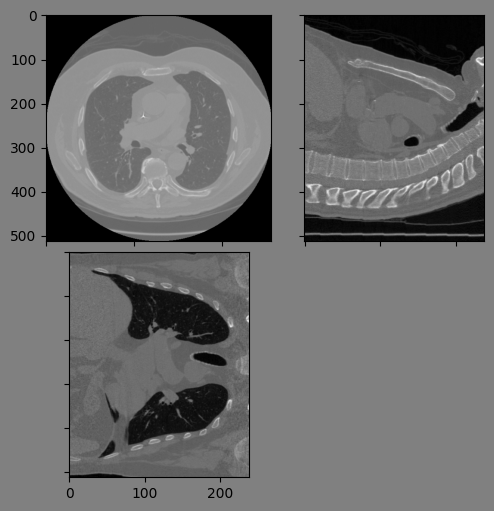

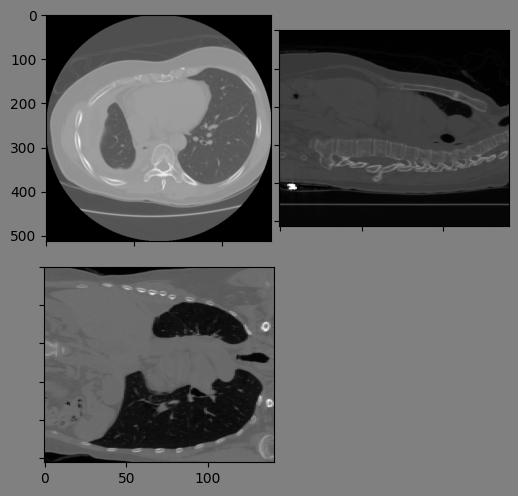

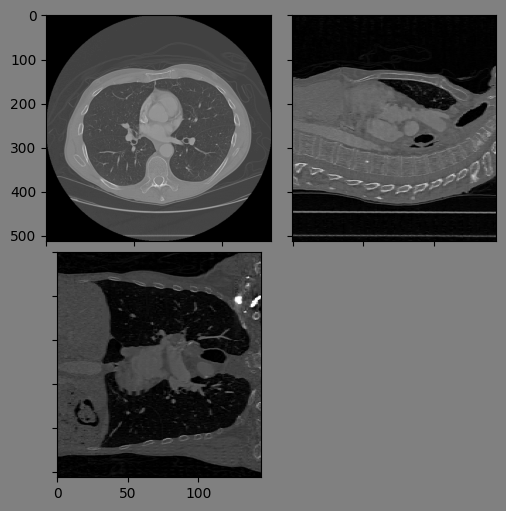

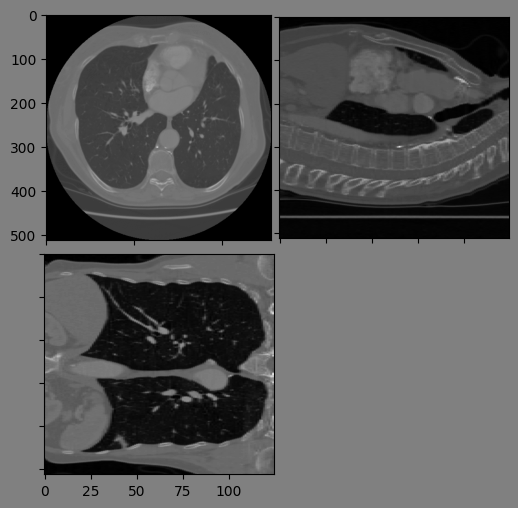

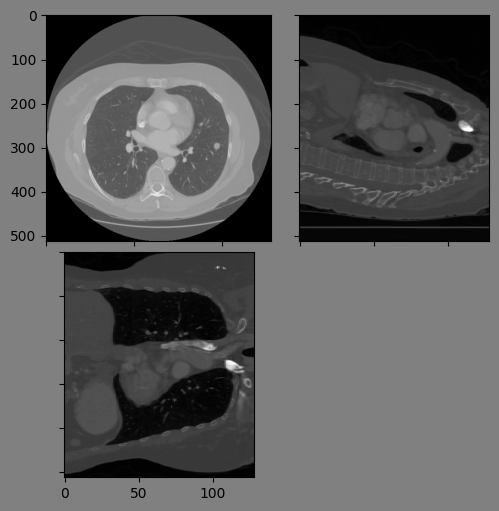

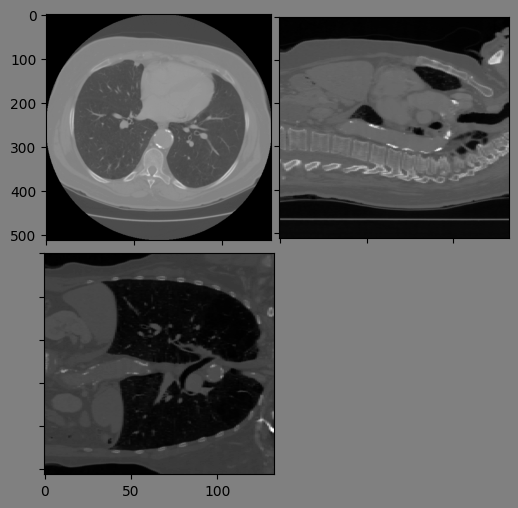

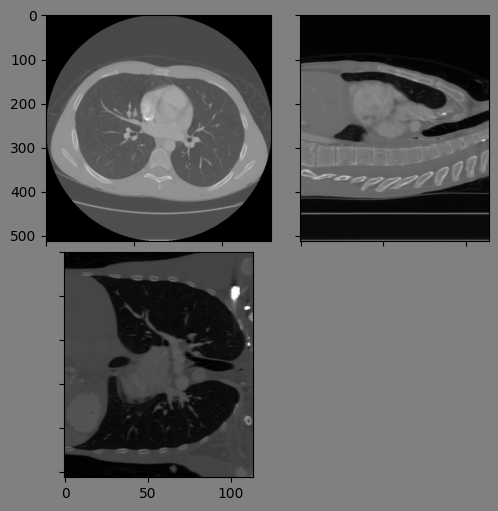

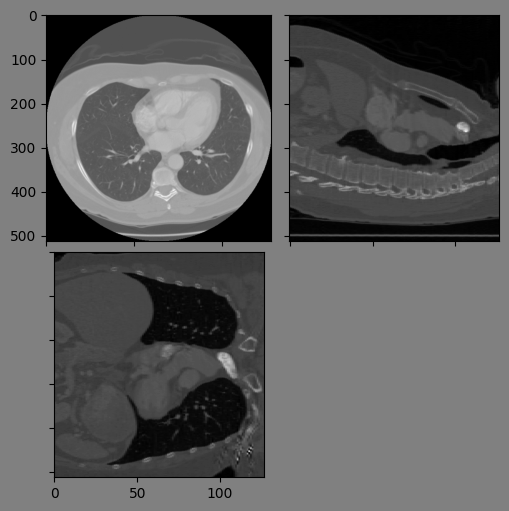

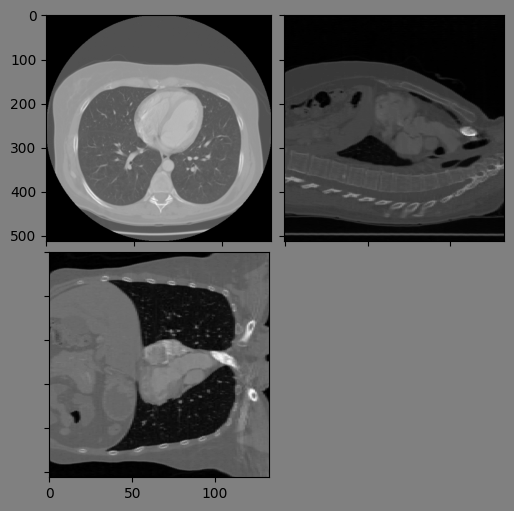

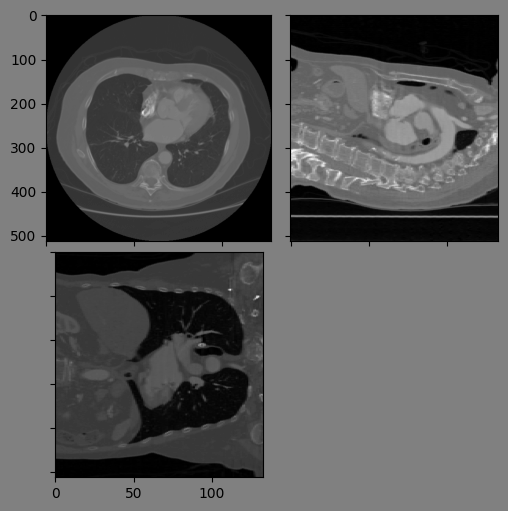

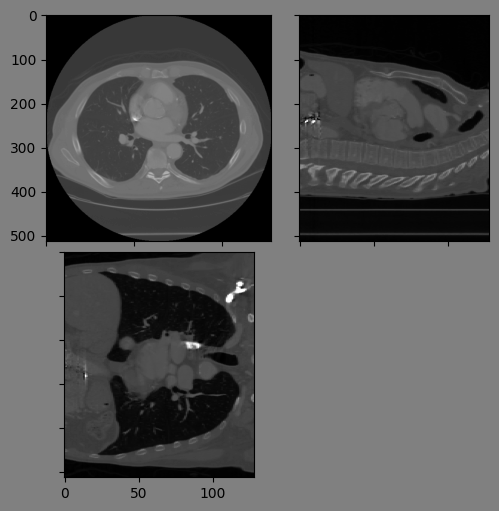

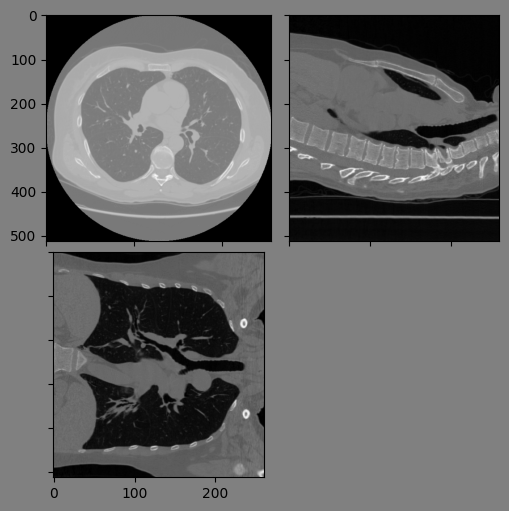

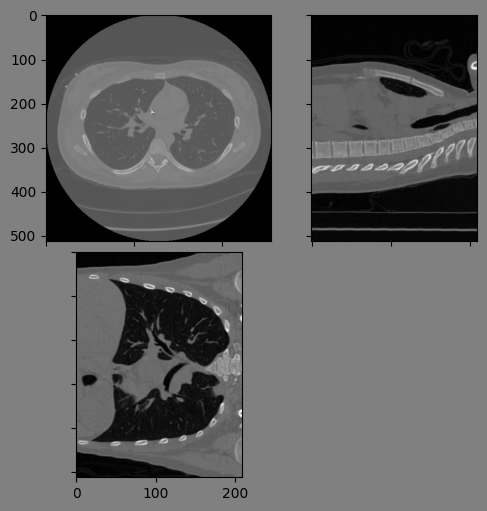

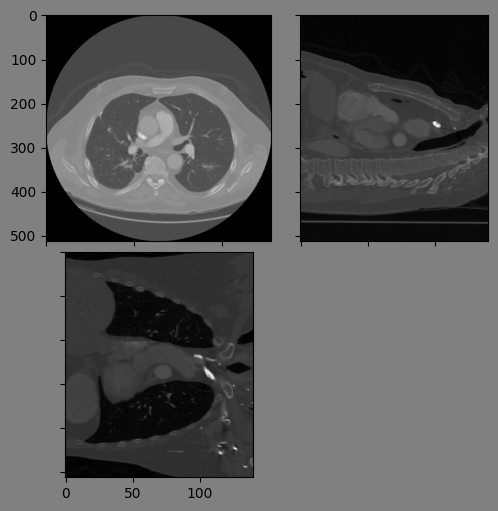

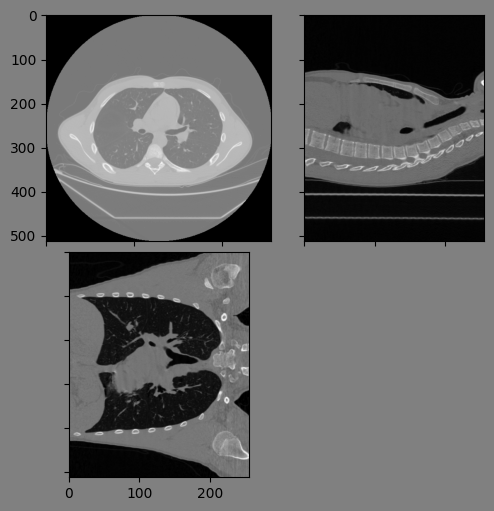

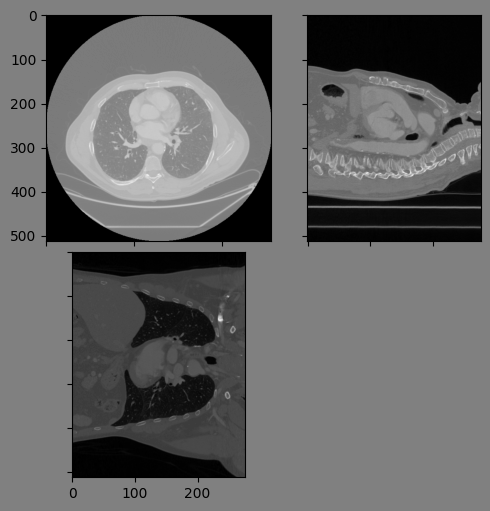

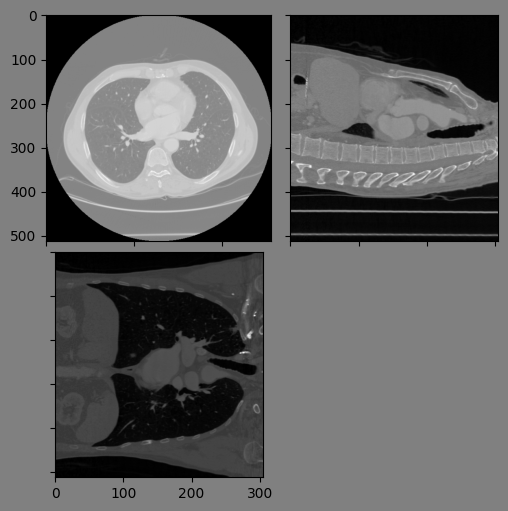

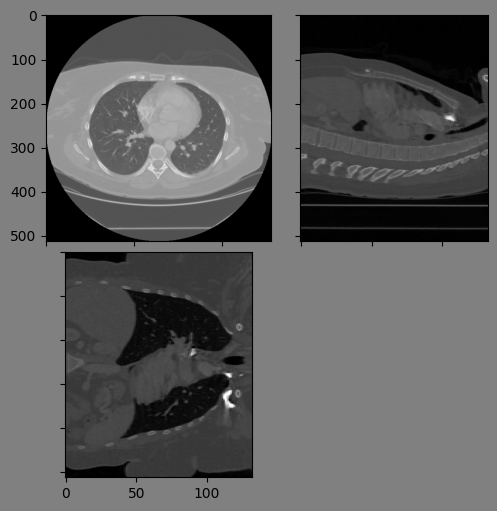

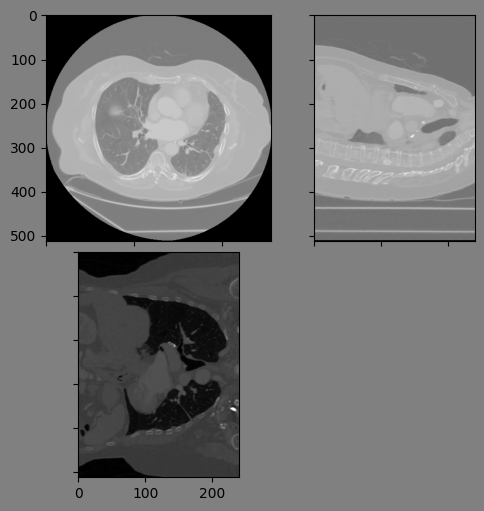

In [113]:

    

for sub_slices in sup_slices: #sub_slices = slices in this section in the original code at github 
    # pixel aspects, assuming all slices are the same
    ps = sub_slices[0].get("PixelSpacing", [1,1])
    ss = sub_slices[0].get("SliceThickness",1)
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ps[0]/ss

    # create 3D array
    img_shape = list(sub_slices[0].pixel_array.shape)
    img_shape.append(len(sub_slices))
    img3d = np.zeros(img_shape)

    # Creating and saving files as nii
    nifti_image = nib.Nifti1Image(img3d, affine = np.eye(4))
    nib.save(nifti_image,outputfolder+"/"+str(sub_slices[0].PatientID))

    # fill 3D array with the images from the files
    for i, s in enumerate(sub_slices):
        img2d = s.pixel_array
        img3d[:, :, i] = img2d

    # plot 3 orthogonal slices
    fig=plt.figure(figsize=(6,6))
    fig.patch.set_facecolor('gray')
    gs1 = gridspec.GridSpec(2,2)
    gs1.update(wspace=0.025, hspace=0.05)

    a1 = plt.subplot(gs1[0])
    plt.imshow(img3d[:, :, img_shape[2]//2], cmap='gray')
    a1.set_aspect(ax_aspect)
    a1.set_xticklabels([])

    a2 = plt.subplot(gs1[1])
    plt.imshow(img3d[:, img_shape[1]//2, :], cmap='gray')
    a2.set_aspect(sag_aspect)
    a2.set_xticklabels([])
    a2.set_yticklabels([])

    a3 = plt.subplot(gs1[2])
    plt.imshow(img3d[img_shape[0]//2, :, :], cmap='gray')
    a3.set_aspect(cor_aspect)
    a3.set_yticklabels([])

    plt.show() 
